In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely import affinity
import contextily as ctx

plt.rcParams['figure.figsize'] = (10, 8)

In [5]:
#1. Preparación de Datos
# Define rutas a los archivos

SHAPE_MUN = 'datos_colombia/municipios_colombia.shp'
EVA_CSV = 'datos_colombia/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV = 'datos_colombia/Catalogo_Estaciones_IDEAM.csv'
ROADS_SHP = 'datos_colombia/RedVial.shp'

# Municipios
gdf_mun = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)

# EVA
eva = pd.read_csv(EVA_CSV)
eva.rename(columns={"CÓD. MUN.": "cod_mun"}, inplace=True)
eva['cod_mun'] = eva['cod_mun'].astype(str).str.zfill(5)

# Estaciones IDEAM
df_est = pd.read_csv(EST_CSV)
coords = df_est['Ubicación'].str.strip('()').str.split(',', expand=True).astype(float)
df_est['lat'], df_est['lon'] = coords[0], coords[1]
gdf_est = gpd.GeoDataFrame(df_est, geometry=gpd.points_from_xy(df_est['lon'], df_est['lat']), crs="EPSG:4326")
gdf_est = gdf_est.to_crs(epsg=9377)

# Carreteras de INVIAS
roads = gpd.read_file(ROADS_SHP).to_crs(epsg=9377)

print(f"{len(gdf_mun):,} municipalities • {len(gdf_est):,} stations • "
      f"{len(eva):,} EVA rows • {len(roads):,} vias")

#Homogenise municipalities codes
gdf_mun["MPIO_CCDGO"] = gdf_mun["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]        = eva["cod_mun"].astype(str).str.zfill(5)


1,122 municipalities • 8,973 stations • 206,068 EVA rows • 653 vias


In [ ]:
#Criterios de Análisis a nivel municpal

In [40]:
# 1. Unión espacial: cada estación tiene los atributos del municipio en el que se encuentra
stations_with_mun = gpd.sjoin(
    gdf_est,                     # capa izquierda: puntos (estaciones IDEAM)
    gdf_mun[["MPIO_CCDGO", "MPIO_CNMBR", "geometry"]],  # capa derecha: polígonos (municipios)
    how="left",
    predicate="within"           # condición: el punto debe estar dentro del polígono
)

# 2. Conteo de estaciones por municipio
est_counts = stations_with_mun.groupby("MPIO_CCDGO").size().reset_index(name='ideam_count')

# 3. Vista previa del resultado
stations_with_mun[["Codigo", "MPIO_CNMBR", "MPIO_CCDGO"]].head()


,Codigo,MPIO_CNMBR,MPIO_CCDGO
0,52057100,IPIALES,00356
1,52055170,CONTADERO,00210
2,52055220,TÚQUERRES,00838
3,44015070,MOCOA,00001
4,48015040,PUERTO NARIÑO,00540


In [45]:
# 1. Cargar red vial y reproyectar
print("Cargue de red vial")
gdf_vias = gpd.read_file(ROADS_SHP).to_crs(epsg=9377)
print(f" Red vial cargada: {len(gdf_vias):,} segmentos")

# 2. Intersección espacial: Vías que caen dentro de municipios
print(" Intersección vías con polígonos municipales")
vias_in_mun = gpd.overlay(gdf_vias, gdf_mun[["MPIO_CCDGO", "geometry"]], how='intersection')
print(f"Vías intersectadas: {len(vias_in_mun):,} segmentos")

#  3. Calcular la longitud de cada segmento vial (en metros)
vias_in_mun['length_m'] = vias_in_mun.geometry.length
print(" Longitudes individuales calculadas.")

# 4. Sumar longitudes por municipio
vias_length = vias_in_mun.groupby("MPIO_CCDGO")['length_m'].sum().reset_index()
vias_length.rename(columns={'length_m': 'total_vial_m'}, inplace=True)
print(f"Longitudes agregadas por municipio: {vias_length.shape[0]:,} municipios")

# 5. Calcular el área de cada municipio (en km²)
gdf_mun['area_km2'] = gdf_mun.geometry.area / 1e6

#  6. Unir con el dataframe de longitud de vías
gdf_mun = gdf_mun.merge(vias_length, on="MPIO_CCDGO", how="left")

# 7. Rellenar nulos donde no hay vías
gdf_mun['total_vial_m'] = gdf_mun['total_vial_m'].fillna(0)

#  8. Calcular densidad vial: metros de vía por km²
gdf_mun['densidad_vial'] = gdf_mun['total_vial_m'] / gdf_mun['area_km2']
print(" Densidad vial (m/km²) calculada.")



Cargue de red vial
 Red vial cargada: 653 segmentos
 Intersección vías con polígonos municipales
Vías intersectadas: 1,512 segmentos
 Longitudes individuales calculadas.
Longitudes agregadas por municipio: 427 municipios
 Densidad vial (m/km²) calculada.


In [52]:
# Caña de azúcar
# Filtrar registros de caña 
cana_eva = eva[eva["CULTIVO"].str.contains("CAÑA", case=False, na=False)]
print(f"Registros de caña encontrados: {len(cana_eva)}")

# Agrupar y sumar la producción total de caña por municipio
cana_prod = (
    cana_eva.groupby("cod_mun")["Producción\n(t)"]
    .sum()
    .reset_index()
    .rename(columns={"cod_mun": "MPIO_CCDGO", "Producción\n(t)": "cana_prod_ton"})
)
print(f"Producción agregada por municipio: {cana_prod.shape[0]} municipios")

# Vista previa del resultado
print(cana_prod.head())

#  merge con gdf_mun:
gdf_mun = gdf_mun.merge(cana_prod, on="MPIO_CCDGO", how="left")
gdf_mun["cana_prod_ton"] = gdf_mun["cana_prod_ton"].fillna(0)



Registros de caña encontrados: 8118
Producción agregada por municipio: 695 municipios
  MPIO_CCDGO  cana_prod_ton
0      05001           6543
1      05002          11758
2      05004           5313
3      05021           7173
4      05030           5126


In [51]:
# Proximidad a vías principales

vias_buffer = gdf_vias.copy()
vias_buffer['geometry'] = vias_buffer.buffer(1000)  # Buffer de 1000 metros (1 km)

buffer_intersection = gpd.overlay(
    vias_buffer[["geometry"]],
    gdf_mun[["MPIO_CCDGO", "geometry"]],
    how='intersection'
)


if buffer_intersection.empty:
    print("La intersección está vacía. Revisa el CRS o geometrías de entrada.")
else:
    print(f" {len(buffer_intersection)} zonas intersectadas entre buffer y municipios")

    # Paso: Calcular el área del buffer que cae en cada municipio
    buffer_intersection["buffer_area"] = buffer_intersection.geometry.area

    # Sumar el área del buffer por municipio
    buffer_area = buffer_intersection.groupby("MPIO_CCDGO")["buffer_area"].sum().reset_index()
    buffer_area.rename(columns={"buffer_area": "buffer_area_m2"}, inplace=True)

    # Unir con municipios
    gdf_mun = gdf_mun.merge(buffer_area, on="MPIO_CCDGO", how="left")

    # Rellenar valores nulos
    gdf_mun["buffer_area_m2"] = gdf_mun["buffer_area_m2"].fillna(0)

    # Calcular proporción del municipio cubierto por el buffer
    gdf_mun["porcentaje_cerca_vias"] = gdf_mun["buffer_area_m2"] / (gdf_mun["area_km2"] * 1e6)

    print("Criterio de proximidad a vías calculado exitosamente.")




 1901 zonas intersectadas entre buffer y municipios
Criterio de proximidad a vías calculado exitosamente.


In [57]:
# Verificar valores nulos en columnas normalizadas
print(" Revisión de nulos por columna:")
print(gdf_mun[["norm_cana", "norm_vial", "norm_estaciones", "norm_cerca_vias"]].isna().sum())

#  Rellenar valores nulos con cero para evitar errores en el ranking
gdf_mun["norm_cana"] = gdf_mun["norm_cana"].fillna(0)
gdf_mun["norm_vial"] = gdf_mun["norm_vial"].fillna(0)
gdf_mun["norm_estaciones"] = gdf_mun["norm_estaciones"].fillna(0)
gdf_mun["norm_cerca_vias"] = gdf_mun["norm_cerca_vias"].fillna(0)

# Asignar pesos a cada criterio (puedes modificar estos valores)
w_cana = 0.4
w_vial = 0.2
w_est = 0.2
w_cerca_vias = 0.2

# Calcular el índice multicriterio (ranking)
gdf_mun["ranking"] = (
    w_cana * gdf_mun["norm_cana"] +
    w_vial * gdf_mun["norm_vial"] +
    w_est * gdf_mun["norm_estaciones"] +
    w_cerca_vias * gdf_mun["norm_cerca_vias"]
)

# Mostrar el mejor municipio según el ranking
if gdf_mun["ranking"].notna().any():
    mejor_municipio = gdf_mun.loc[gdf_mun["ranking"].idxmax()]
    print("Municipio óptimo seleccionado:")
    print(mejor_municipio[["MPIO_CNMBR", "ranking"]])

# Ordenar por ranking descendente y mostrar los primeros 5 municipios
top_5 = gdf_mun.sort_values(by="ranking", ascending=False)[["MPIO_CNMBR", "ranking"]].head(5)
print(" Top 5 municipios mejor posicionados:")
print(top_5)


 Revisión de nulos por columna:
norm_cana          0
norm_vial          0
norm_estaciones    0
norm_cerca_vias    0
dtype: int64
Municipio óptimo seleccionado:
MPIO_CNMBR    SAN ANDRÉS
ranking              0.6
Name: 628, dtype: object
 Top 5 municipios mejor posicionados:
        MPIO_CNMBR   ranking
628     SAN ANDRÉS  0.600000
867   AGUA DE DIOS  0.327169
637          TUNJA  0.291182
256        ARMENIA  0.289598
1061   BUCARAMANGA  0.271381


In [ ]:
#Se selecciona a San Andres

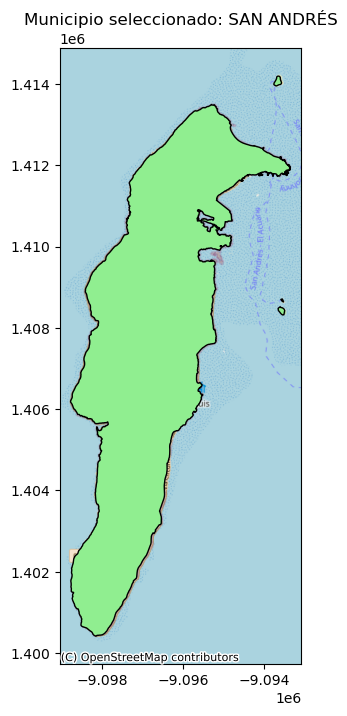

In [8]:
#Level 2

# Filtrar San Andrés del conjunto de municipios
municipio_optimo = gdf_mun[
    (gdf_mun["MPIO_CNMBR"].str.upper() == "SAN ANDRÉS") &
    (gdf_mun["DPTO_CCDGO"] == "88")
].copy()

# Confirmar selección
ax = municipio_optimo.to_crs(epsg=3857).plot(edgecolor="black", facecolor="lightgreen")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Municipio seleccionado: SAN ANDRÉS")
plt.show()

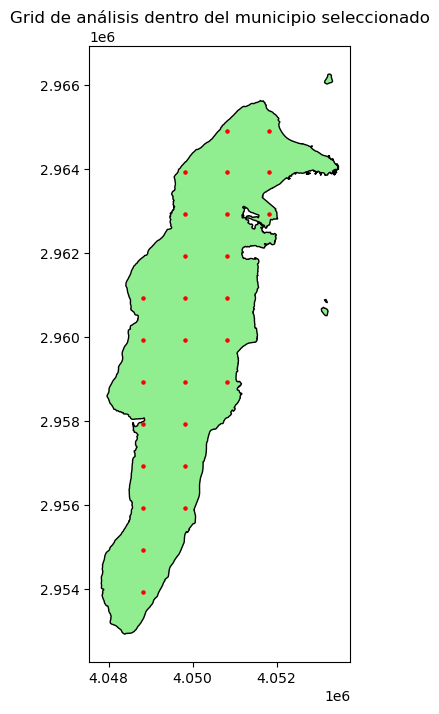

In [9]:
#Mapa de puntos 

from shapely.geometry import box

# Bounding box del municipio
bounds = municipio_optimo.total_bounds
xmin, ymin, xmax, ymax = bounds

# Definir resolución del grid
res = 1000  # 1 km

# Crear malla de puntos
cols = list(np.arange(xmin, xmax, res))
rows = list(np.arange(ymin, ymax, res))
points = [Point(x, y) for x in cols for y in rows]

# Convertir a GeoDataFrame y filtrar los puntos que están dentro del municipio
grid = gpd.GeoDataFrame(geometry=points, crs=municipio_optimo.crs)
grid = grid[grid.within(municipio_optimo.geometry.values[0])]

# Visualizar
ax = municipio_optimo.plot(edgecolor="black", facecolor="lightgreen")
grid.plot(ax=ax, color="red", markersize=5)
plt.title("Grid de análisis dentro del municipio seleccionado")
plt.show()


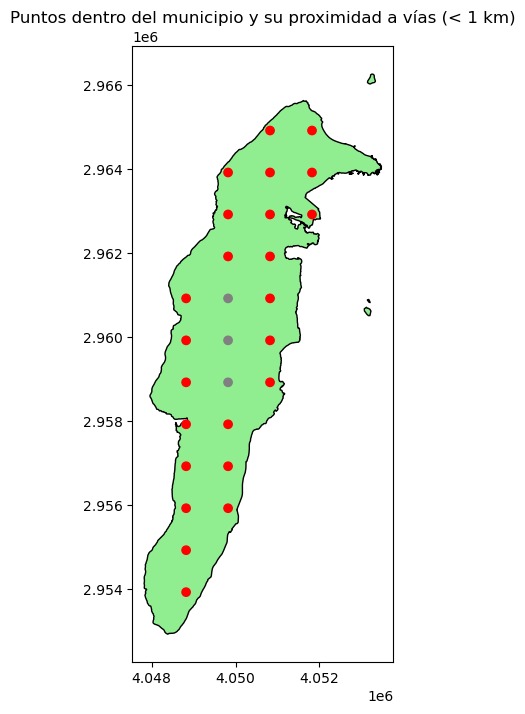

In [12]:
# 1. Cargar las vías y reproyectar
ROADS_SHP = "datos_colombia/RedVial.shp"
gdf_vias = gpd.read_file(ROADS_SHP).to_crs(epsg=9377)

# 2. Filtrar puntos del grid que están dentro del municipio
puntos_en_mun = grid[grid.intersects(municipio_optimo.geometry.union_all())].copy()

# 3. Calcular distancia de cada punto a la vía más cercana
puntos_en_mun["dist_a_via"] = puntos_en_mun.geometry.apply(
    lambda punto: gdf_vias.distance(punto).min()
)

# 4. Marcar puntos que están a menos de 1 km de una vía
puntos_en_mun["cerca_de_via"] = puntos_en_mun["dist_a_via"] < 1000  # en metros

# 5. Visualizar
ax = municipio_optimo.to_crs(epsg=9377).plot(edgecolor="black", facecolor="lightgreen")
puntos_en_mun.plot(ax=ax, color=puntos_en_mun["cerca_de_via"].map({True: "red", False: "gray"}))
plt.title("Puntos dentro del municipio y su proximidad a vías (< 1 km)")
plt.show()


Áreas protegidas cargadas: 1785
Áreas RUNAP dentro del municipio: 3


Text(0.5, 1.0, 'Áreas protegidas (RUNAP) dentro del municipio seleccionado')

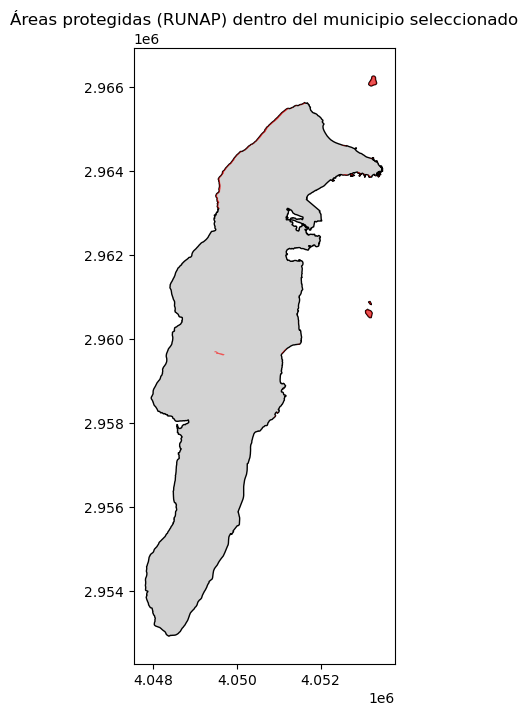

In [16]:
import geopandas as gpd

# 1. Cargar RUNAP (Áreas protegidas) y reproyectar a EPSG:9377
runap = gpd.read_file("datos_colombia/latest/runap.shp").to_crs(epsg=9377)
print(f"Áreas protegidas cargadas: {len(runap)}")

# 2. Filtrar RUNAP que intersecta con el municipio seleccionado
runap_municipio = gpd.overlay(runap, municipio_optimo, how='intersection')
print(f"Áreas RUNAP dentro del municipio: {len(runap_municipio)}")

# 3. Visualización rápida
ax = municipio_optimo.plot(color="lightgrey", edgecolor="black", linewidth=1)
runap_municipio.plot(ax=ax, color="red", alpha=0.6)
ax.set_title("Áreas protegidas (RUNAP) dentro del municipio seleccionado")



Antes de excluir RUNAP: 27 puntos
Puntos después de excluir RUNAP: 27


/tmp/ipykernel_51/1319314626.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_runap = runap_municipio.geometry.unary_union


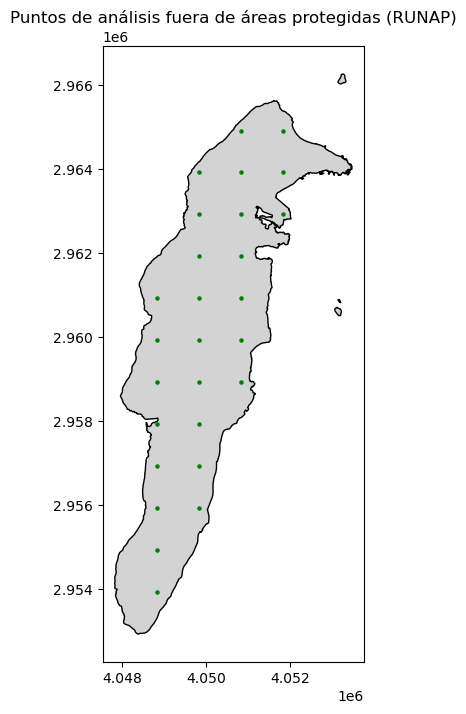

In [17]:
# Excluir puntos del grid que intersectan con RUNAP
print(f"Antes de excluir RUNAP: {len(puntos_en_mun)} puntos")

# Usar `.intersects` con geometría unificada de RUNAP
if not runap_municipio.empty:
    union_runap = runap_municipio.geometry.unary_union
    puntos_validos = puntos_en_mun[~puntos_en_mun.geometry.intersects(union_runap)].copy()
else:
    puntos_validos = puntos_en_mun.copy()  # si no hay RUNAP, usar todos los puntos

print(f"Puntos después de excluir RUNAP: {len(puntos_validos)}")

# Visualización de puntos válidos
ax = municipio_optimo.plot(color="lightgrey", edgecolor="black")
puntos_validos.plot(ax=ax, color="green", markersize=5)
plt.title("Puntos de análisis fuera de áreas protegidas (RUNAP)")
plt.show()


Mejor ubicación local seleccionada:
geometry    POINT (4048822.4544663434 2957919.524561753)
score                                           0.981437
Name: 19, dtype: object


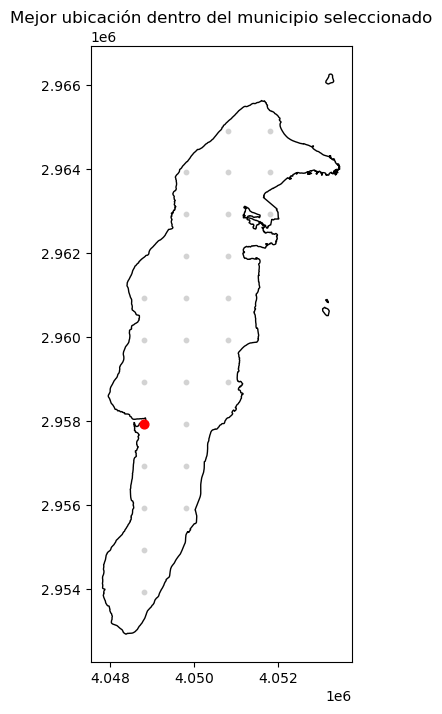

In [18]:
#Calculo de criterios en el grid

from sklearn.preprocessing import MinMaxScaler

# 1. Distancia a vía (ya lo habíamos calculado antes)
puntos_validos["dist_a_via"] = puntos_validos.geometry.apply(
    lambda punto: gdf_vias.distance(punto).min()
)

# 2. Distancia a estación IDEAM
puntos_validos["dist_a_estacion"] = puntos_validos.geometry.apply(
    lambda punto: gdf_est.distance(punto).min()
)

# 3. Variable binaria: ¿está dentro del buffer de 1 km de alguna vía?
puntos_validos["cerca_via"] = puntos_validos["dist_a_via"] < 1000

# 4. Normalizar variables cuantitativas (inversas, porque menor distancia = mejor)
scaler = MinMaxScaler()
puntos_validos[["norm_dist_via", "norm_dist_est"]] = 1 - scaler.fit_transform(
    puntos_validos[["dist_a_via", "dist_a_estacion"]]
)

# 5. Convertir variable binaria a 0/1
puntos_validos["cerca_via"] = puntos_validos["cerca_via"].astype(int)

# 6. Índice compuesto: ponderación
w_via = 0.4
w_est = 0.3
w_cerca = 0.3

puntos_validos["score"] = (
    w_via * puntos_validos["norm_dist_via"] +
    w_est * puntos_validos["norm_dist_est"] +
    w_cerca * puntos_validos["cerca_via"]
)

# 7. Seleccionar mejor punto
mejor_punto = puntos_validos.loc[puntos_validos["score"].idxmax()]

print("Mejor ubicación local seleccionada:")
print(mejor_punto[["geometry", "score"]])

# 8. Visualización
ax = municipio_optimo.plot(color="white", edgecolor="black")
puntos_validos.plot(ax=ax, color="lightgrey", markersize=10)
gpd.GeoSeries(mejor_punto.geometry).plot(ax=ax, color="red", markersize=40)
plt.title("Mejor ubicación dentro del municipio seleccionado")
plt.show()



Área del polígono candidato: 4.98 km²


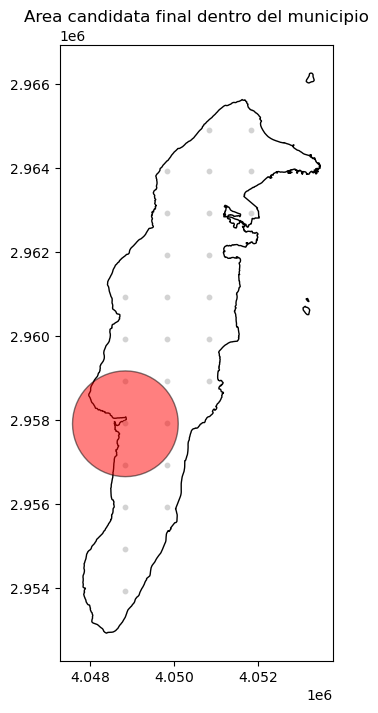

In [19]:
# 1. Crear buffer de 1.26 km (1260 metros)
radio_m = 1260
area_candidata = gpd.GeoDataFrame(
    geometry=[mejor_punto.geometry.buffer(radio_m)],
    crs="EPSG:9377"
)

# 2. Verificar área del buffer (en m²)
area_m2 = area_candidata.geometry.area.iloc[0]
print(f"Área del polígono candidato: {area_m2/1e6:.2f} km²")

# 3. Visualización
ax = municipio_optimo.plot(color="white", edgecolor="black")
puntos_validos.plot(ax=ax, color="lightgrey", markersize=10)
area_candidata.plot(ax=ax, facecolor="red", edgecolor="black", alpha=0.5)
plt.title("Area candidata final dentro del municipio")
plt.show()


In [ ]:
#A partir del analisis multicriterio se determino que el lugar mas idoneo es San Andres